In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
import jieba.analyse
from wordcloud import WordCloud
from matplotlib.font_manager import FontProperties

plt.style.use("seaborn-whitegrid")

In [22]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['STZhongsong']    # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False           # 解决保存图像是负号'-'显示为方块的问题

In [25]:
%config InlineBackend.figure_format = 'retina' # 导出的图片清晰度更高

# 数据预处理

In [27]:
Comment_data = pd.read_csv('data/JDComment_HPzhan99_全部.csv')  # 读取训练数据
# Comment_data = pd.read_csv('data/JDComment_HPzhan99_all.csv')  # 读取训练数据
# 把属性名改为英文
Comment_data.rename(columns={'用户ID': 'userId', '评论内容': 'content', '购买时间': 'boughtTime', '点赞数': 'voteCount',
                                '回复数': 'replyCount', '评分': 'score', '评价时间': 'creationTime', '产品型号': 'referenceName'},
                          inplace=True)

In [28]:
Comment_data.isnull().any() #查看是否有缺失值

userId           False
content          False
boughtTime       False
voteCount        False
replyCount       False
score            False
creationTime     False
referenceName    False
dtype: bool

In [29]:
print("评论总数：", len(Comment_data)) #统计评论总数
# 把含有"此用户未及时填写评价内容的评论内容"的评论改为空
Comment_data['content'] = Comment_data['content'].apply(lambda x: "" if x == "此用户未及时填写评价内容" else x)
Comment_data['content'] = Comment_data['content'].apply(lambda x: "" if x == "此用户未填写评价内容" else x)
print("有效评论数：", len(Comment_data[Comment_data['content']!=""])) #统计有效评论数

评论总数： 1001
有效评论数： 983


In [30]:
Comment_data_ori = Comment_data.copy()
# Comment_data = Comment_data_ori.copy()
Comment_data = Comment_data.drop_duplicates("userId")

# 描述性分析

Text(0.5, 1.0, '评分分布情况')

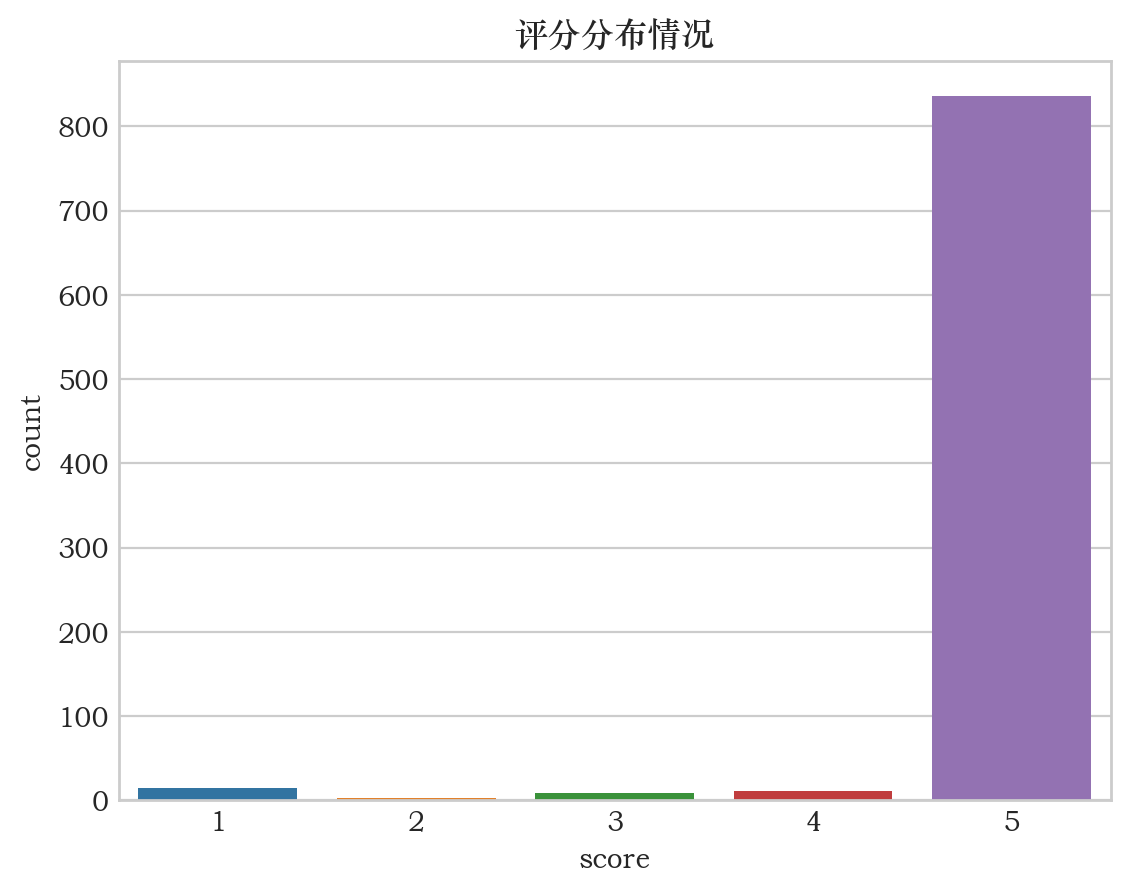

In [31]:
# 查看评分分布情况
Comment_data['score'].value_counts()
# 绘制直方图
sns.countplot(x='score',data=Comment_data)
plt.xlabel('score')
plt.title('评分分布情况')

[Text(0, 0, '好评'), Text(1, 0, '中评'), Text(2, 0, '差评')]

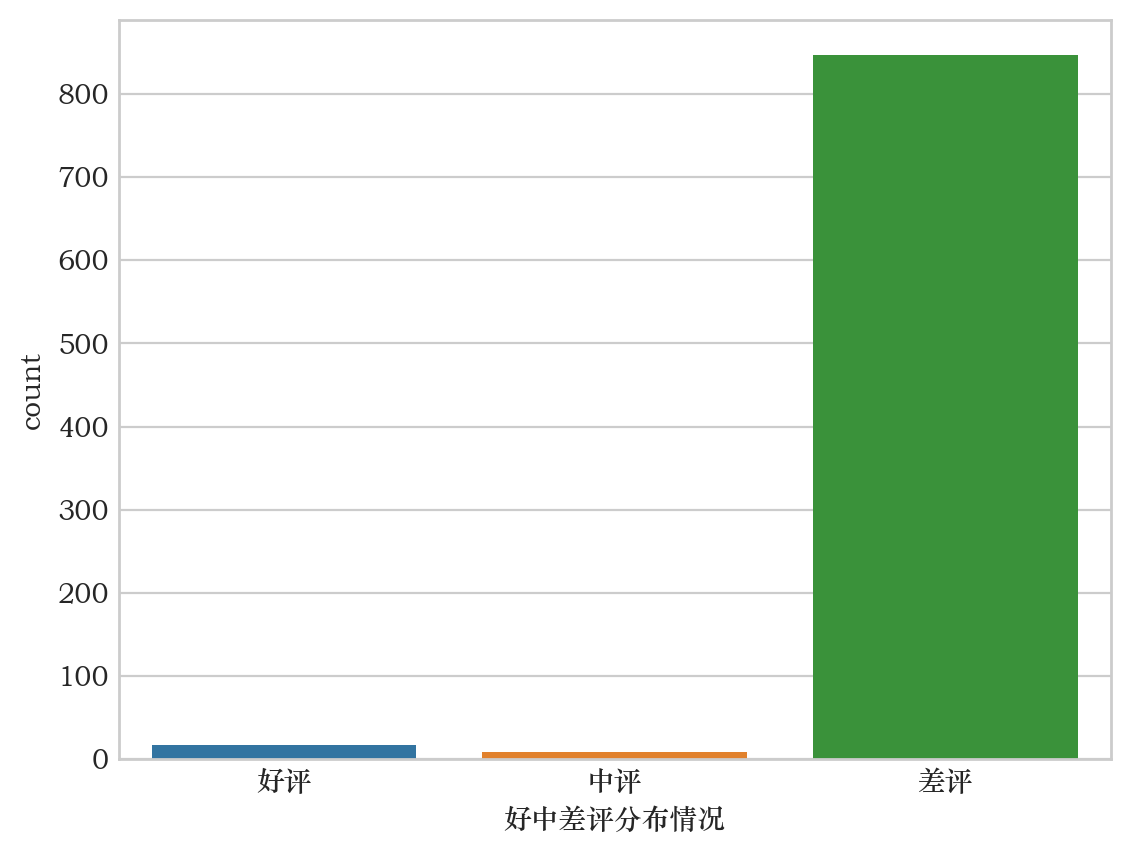

In [32]:
# 查看评分随时间的变化
Comment_data['creationTime'] = pd.to_datetime(Comment_data['creationTime']) #转换为时间格式
# 将4，5算为positive, 1，2算为negative，3算为neutral
Comment_data['Sentiment'] = Comment_data['score'].apply(lambda x: 'positive' if x > 3 else 'negative' if x < 3 else 'neutral')

class_names = ['好评', '中评', '差评']
ax = sns.countplot(x='Sentiment',data=Comment_data)
plt.xlabel('好中差评分布情况')
ax.set_xticklabels(class_names)

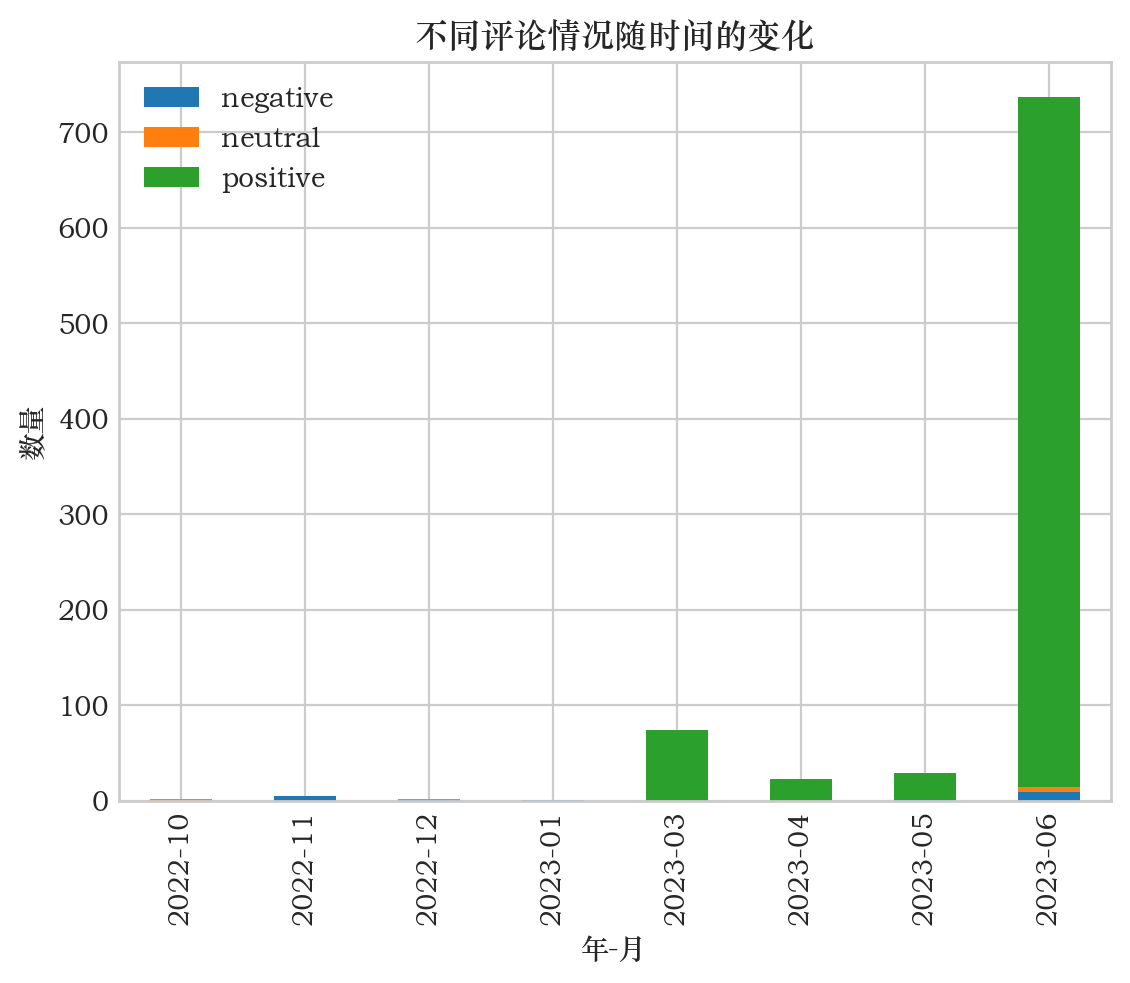

In [11]:
# 绘制不同sentiment数量随时间的变化的堆叠图，以月为groupby单位,每个sentiment
Comment_data['month'] = Comment_data['creationTime'].dt.month
Comment_data['year'] = Comment_data['creationTime'].dt.year
Comment_data['month_year'] = Comment_data['creationTime'].dt.to_period('M').astype(str)
Comment_data['month_year'] = pd.to_datetime(Comment_data['month_year'])
Comment_data['month_year'] = Comment_data['month_year'].dt.strftime('%Y-%m')

# 绘制不同sentiment数量随时间的变化的堆叠图，以月为groupby单位,每个sentiment一种颜色
Comment_data.groupby(['month_year', 'Sentiment']).size().unstack().plot(kind='bar', stacked=True)
plt.title('不同评论情况随时间的变化')
plt.xlabel('年-月')
plt.ylabel('数量')
plt.legend(loc='upper left')
plt.show()

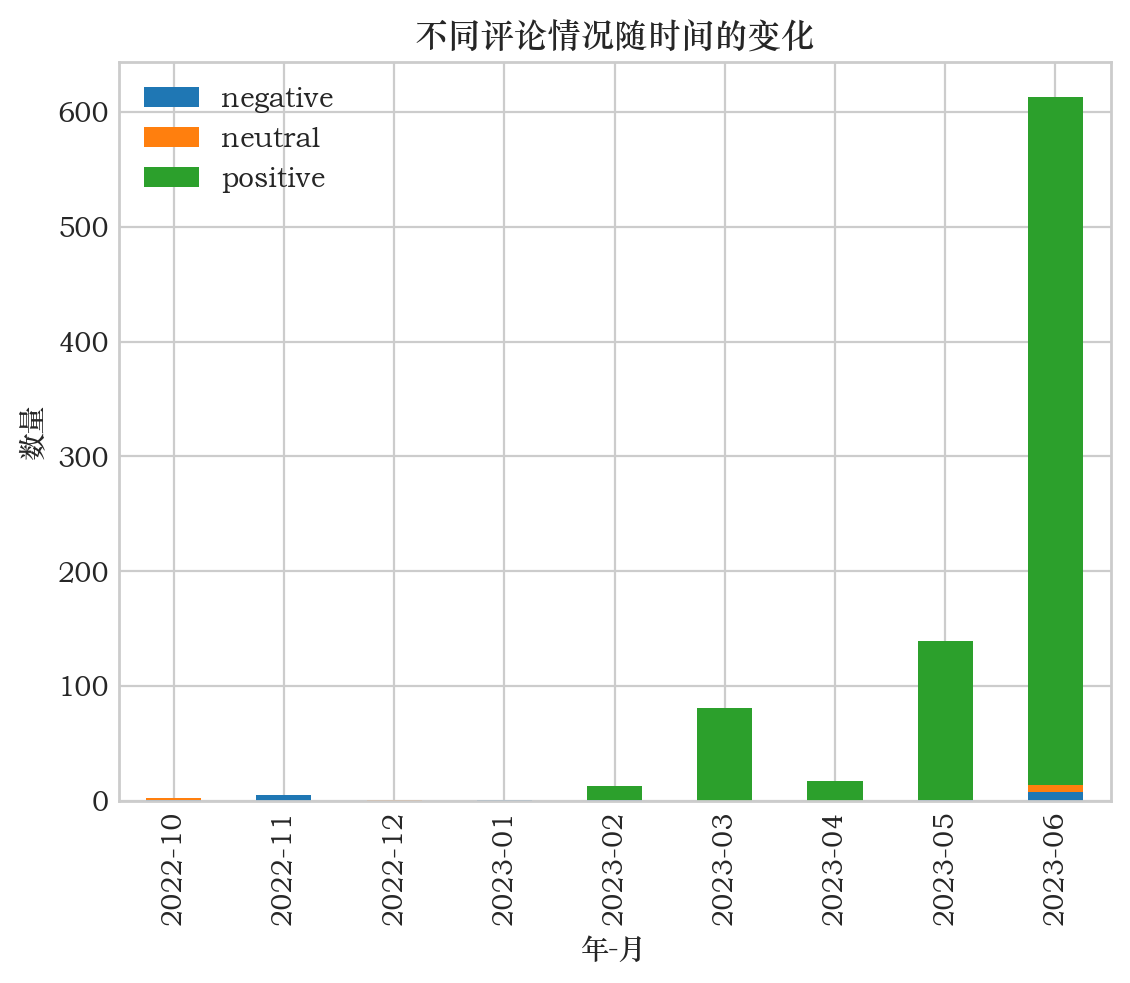

In [33]:
# 绘制不同sentiment数量随时间的变化的堆叠图，以月为groupby单位,每个sentiment
Comment_data['boughtTime'] = pd.to_datetime(Comment_data['boughtTime']) #转换为时间格式
Comment_data['bmonth'] = Comment_data['boughtTime'].dt.month
Comment_data['byear'] = Comment_data['boughtTime'].dt.year
Comment_data['bmonth_year'] = Comment_data['boughtTime'].dt.to_period('M').astype(str)
Comment_data['bmonth_year'] = pd.to_datetime(Comment_data['bmonth_year'])
Comment_data['bmonth_year'] = Comment_data['bmonth_year'].dt.strftime('%Y-%m')

# 绘制不同sentiment数量随时间的变化的堆叠图，以月为groupby单位,每个sentiment一种颜色
Comment_data.groupby(['bmonth_year', 'Sentiment']).size().unstack().plot(kind='bar', stacked=True)
plt.title('不同评论情况随时间的变化')
plt.xlabel('年-月')
plt.ylabel('数量')
plt.legend(loc='upper left')
plt.show()

In [13]:
Comment_data_rec = Comment_data[Comment_data['creationTime']>"2023-01-01"]

Text(0.5, 0, '评分分布情况')

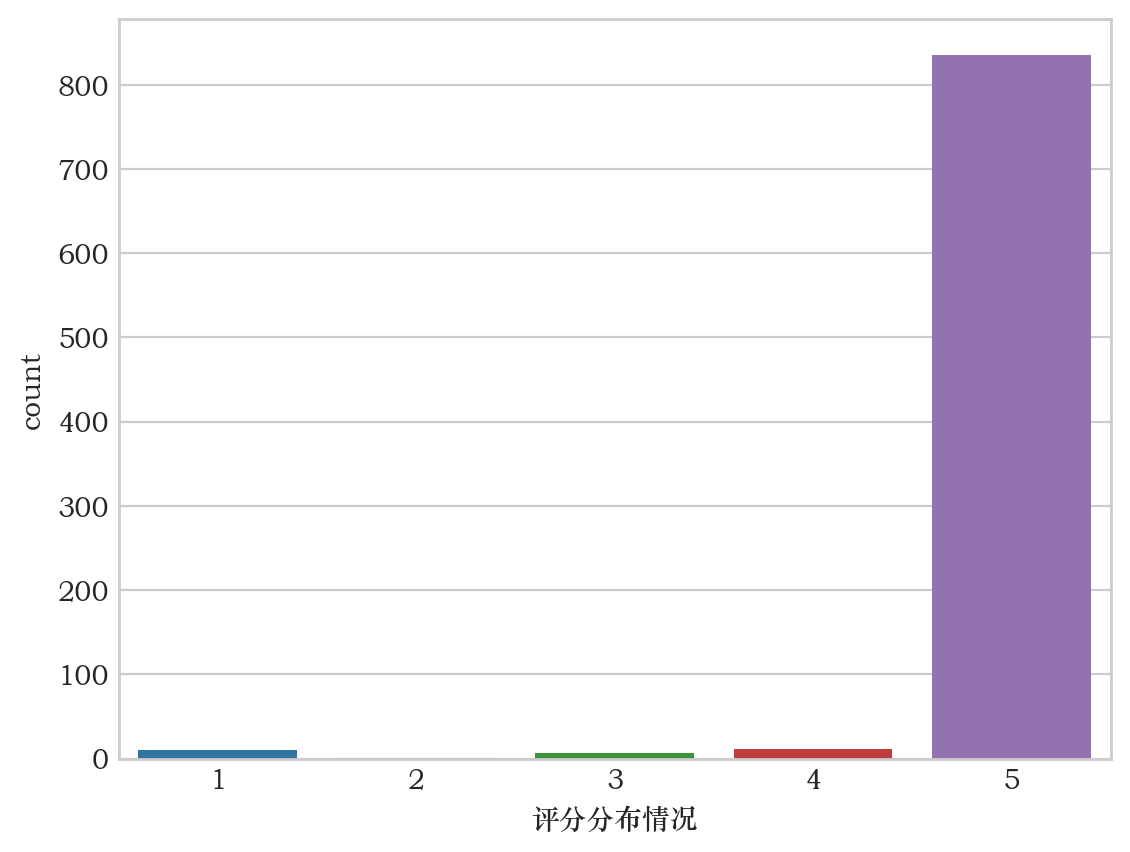

In [14]:
# 查看评分分布情况
Comment_data_rec['score'].value_counts()
# 绘制直方图
sns.countplot(x='score',data=Comment_data_rec)
plt.xlabel('评分分布情况')

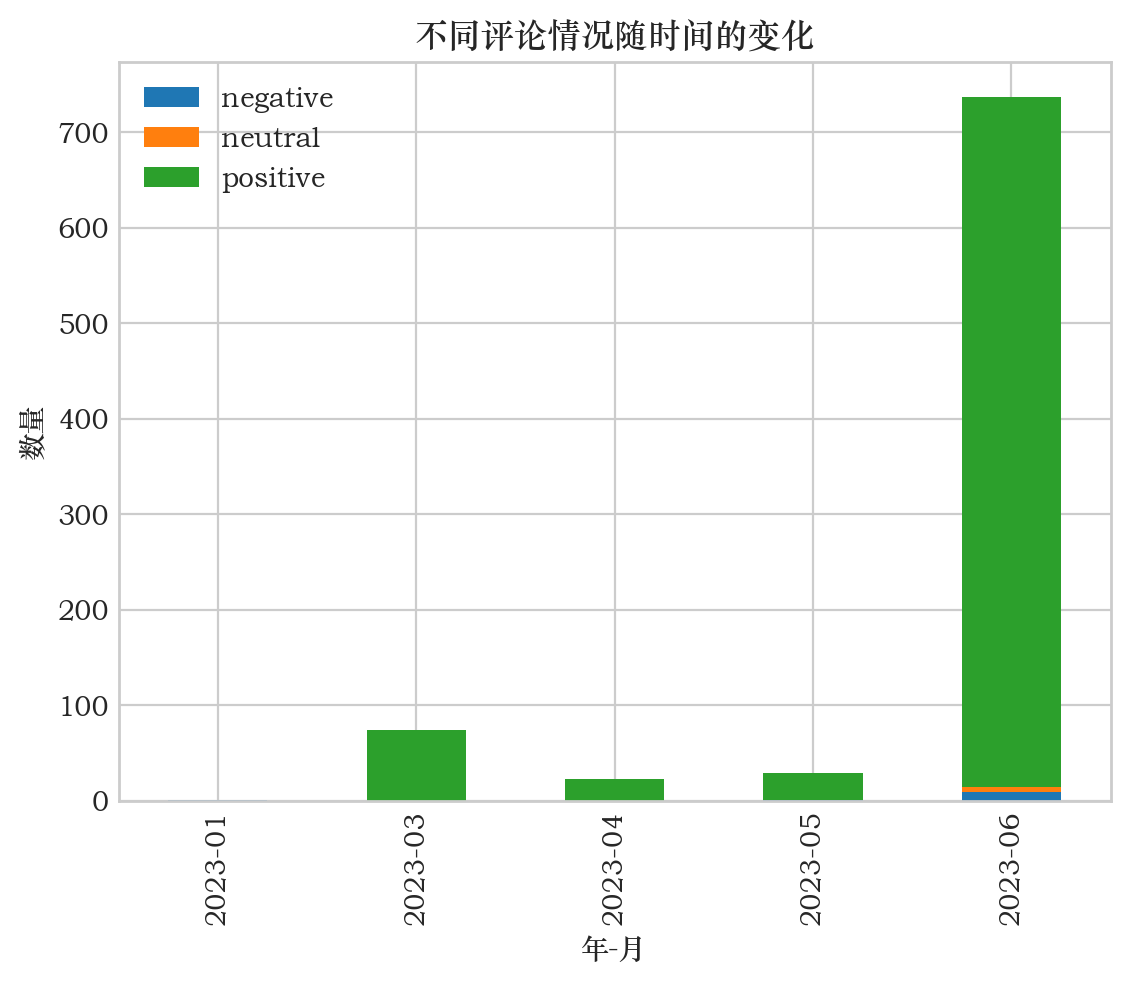

In [15]:
# 绘制不同sentiment数量随时间的变化的堆叠图，以月为groupby单位,每个sentiment一种颜色
Comment_data_rec.groupby(['month_year', 'Sentiment']).size().unstack().plot(kind='bar', stacked=True)
plt.title('不同评论情况随时间的变化')
plt.xlabel('年-月')
plt.ylabel('数量')
plt.legend(loc='upper left')
plt.show()

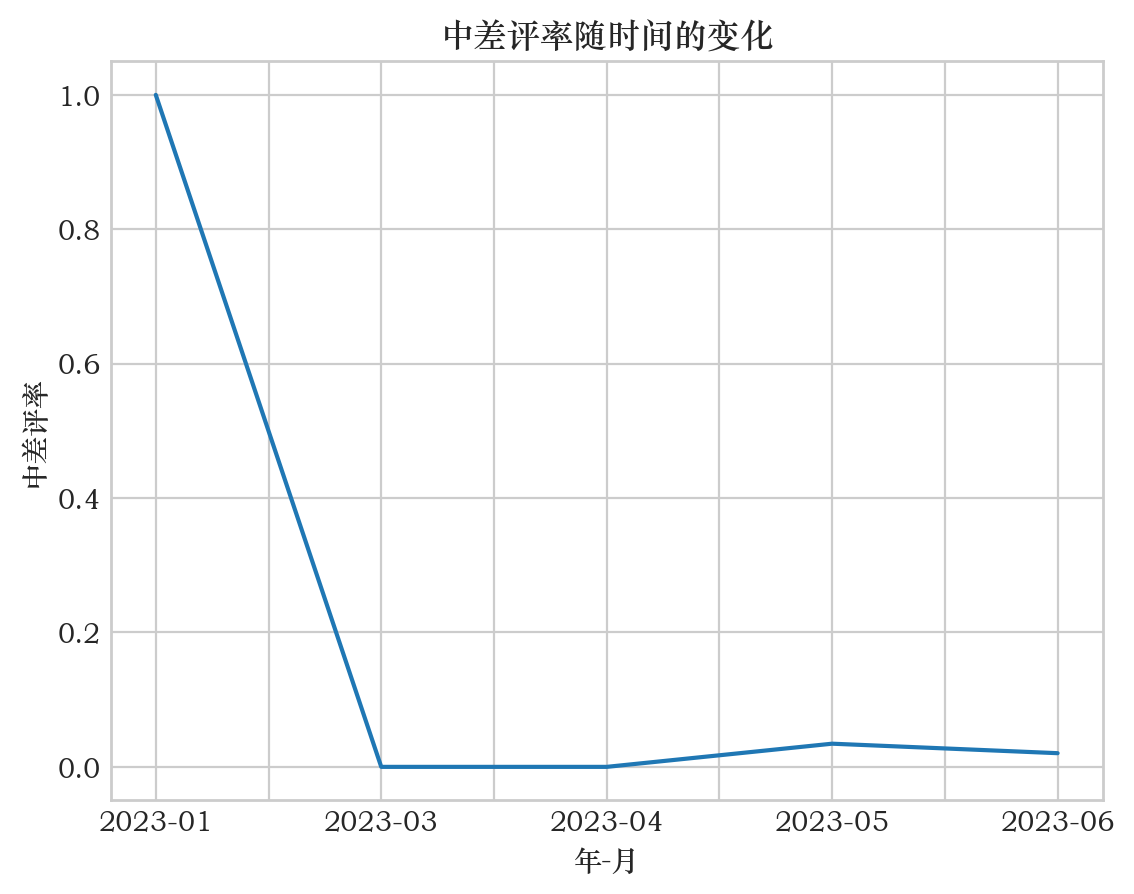

In [16]:
# 统计每月positive占当月所有评论的比，并绘制每月中差率折线图
Comment_data_rec['positive'] = Comment_data_rec['Sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
Comment_data_rec['negative'] = Comment_data_rec['Sentiment'].apply(lambda x: 1 if x == 'negative' else 0)
Comment_data_rec['neutral'] = Comment_data_rec['Sentiment'].apply(lambda x: 1 if x == 'neutral' else 0)
Comment_data_rec['nonPos_rate'] = 1-Comment_data_rec['positive'] / (Comment_data_rec['positive'] + Comment_data_rec['negative'] + Comment_data_rec['neutral'])
Comment_data_rec['nonPos_rate'] = Comment_data_rec['nonPos_rate'].apply(lambda x: round(x, 2))
Comment_data_rec.groupby(['month_year'])['nonPos_rate'].mean().plot()
plt.title('中差评率随时间的变化')
plt.xlabel('年-月')
plt.ylabel('中差评率')
plt.show()


# 词云图

In [17]:
# 数据预处理函数

def preprocess_comment_data(file_path):
    """
    预处理评论数据

    参数:
        file_path (str): 数据文件路径

    返回:
        pd.DataFrame: 处理后的评论数据
    """
    # 读取训练数据
    Comment_data = pd.read_csv(file_path)

    # 把属性名改为英文
    Comment_data.rename(columns={'用户ID': 'userId', '评论内容': 'content', '购买时间': 'boughtTime', '点赞数': 'voteCount',
                                 '回复数': 'replyCount', '评分': 'score', '评价时间': 'creationTime', '产品型号': 'referenceName'},
                       inplace=True)

    # 把含有"此用户未及时填写评价内容的评论内容"的评论改为空
    Comment_data['content'] = Comment_data['content'].apply(lambda x: "" if x == "此用户未及时填写评价内容" else x)

    # 规范时间格式
    Comment_data['creationTime'] = pd.to_datetime(Comment_data['creationTime']) #转换为时间格式
    # 将4，5算为positive, 1，2算为negative，3算为neutral
    Comment_data['Sentiment'] = Comment_data['score'].apply(lambda x: 'positive' if x > 3 else 'negative' if x < 3 else 'neutral')

    # 将评论内容中含有"运行速度","屏幕效果","外形外观","散热性能"中间任意一词的评论删除
    Comment_data_self = Comment_data[~Comment_data['content'].str.contains("运行速度|屏幕效果|外形外观|散热性能")]

    return Comment_data_self


In [18]:
# 定义一个生成词云图的函数

def generate_wordcloud(comment_data, stopwords_file): #, save_file
    """
    生成词云图

    参数:
        comment_data (list): 评论内容列表
        stopwords_file (str): 停用词文件路径
        save_file (str): 保存词云图的文件路径
    """
    # 读取停用词
    stopwords = [line.strip() for line in open(stopwords_file, encoding='UTF-8').readlines()]
    # 添加自定义停用词
    stopwords += ['电脑', '非常', '京东', '一直', '一款', '一点', '完全','hellip']

    # 读取评论内容
    text = ''
    for line in comment_data:
        text += ' '.join(jieba.cut(line, cut_all=False))

    # 生成词云
    wordcloud = WordCloud(font_path="simhei.ttf", 
                          background_color="white", 
                          width=1200,
                          height=1000,
                          stopwords=stopwords,
                          scale=4).generate(text)

    # 显示词云图片
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

    # # 保存图片
    # wordcloud.to_file(save_file)


In [19]:
# 定义一个生成词频统计的函数

def generate_word_frequency_plot(comment_data, stopwords_file):
    """
    生成词频柱状图

    参数:
        comment_data (list): 评论内容列表
        stopwords_file (str): 停用词文件路径
    """
    # 读取评论内容
    text = ''
    for line in comment_data:
        text += ' '.join(jieba.cut(line, cut_all=False))

    # 去除停用词，包括cn_stopwords.txt和自定义停用词
    stopwords = [line.strip() for line in open(stopwords_file, encoding='UTF-8').readlines()]
    stopwords += ['电脑', '非常', '京东', '一直', '一款', '一点', '完全','hellip','笔记本','联想','惠普']
    # 存储为自定义停用词文件
    with open('self_stopwords.txt', 'w', encoding='UTF-8') as file:
        file.write('\n'.join(stopwords))

    jieba.analyse.set_stop_words('self_stopwords.txt')
    jieba.add_word('比官网贵')

    # 导入中文字体
    font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)

    # 提取关键词
    keywords = jieba.analyse.extract_tags(text, topK=10, withWeight=True, allowPOS=('n', 'nr', 'ns'))

    # 生成数据
    reversed_keywords = keywords[::-1]
    x = [i[0] for i in reversed_keywords]
    y = [i[1] for i in reversed_keywords]

    # 绘图
    plt.barh(x, y)
    plt.title("全部评论关键词词频统计", fontproperties=font)
    plt.xlabel("词频", fontproperties=font)
    plt.ylabel("关键词", fontproperties=font)
    plt.show()

## HP战99

In [17]:
# 数据读取及预处理
file_path = 'data/JDComment_ThinkPadP15v_i7T600.csv'

# 调用函数进行评论数据预处理
data = preprocess_comment_data(file_path)

In [ ]:
# 数据
# 所有评论
comment = data['content']
# 中差评
nonPos_comment = data[data['Sentiment'] != 'positive']['content']

In [20]:
# 数据
data = Comment_data_rec
# 所有评论
comment = data['content']
# 中差评
nonPos_comment = data[data['Sentiment'] != 'positive']['content']

### 全部评论

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Lenovo\AppData\Local\Temp\jieba.cache
Loading model cost 0.392 seconds.
Prefix dict has been built successfully.


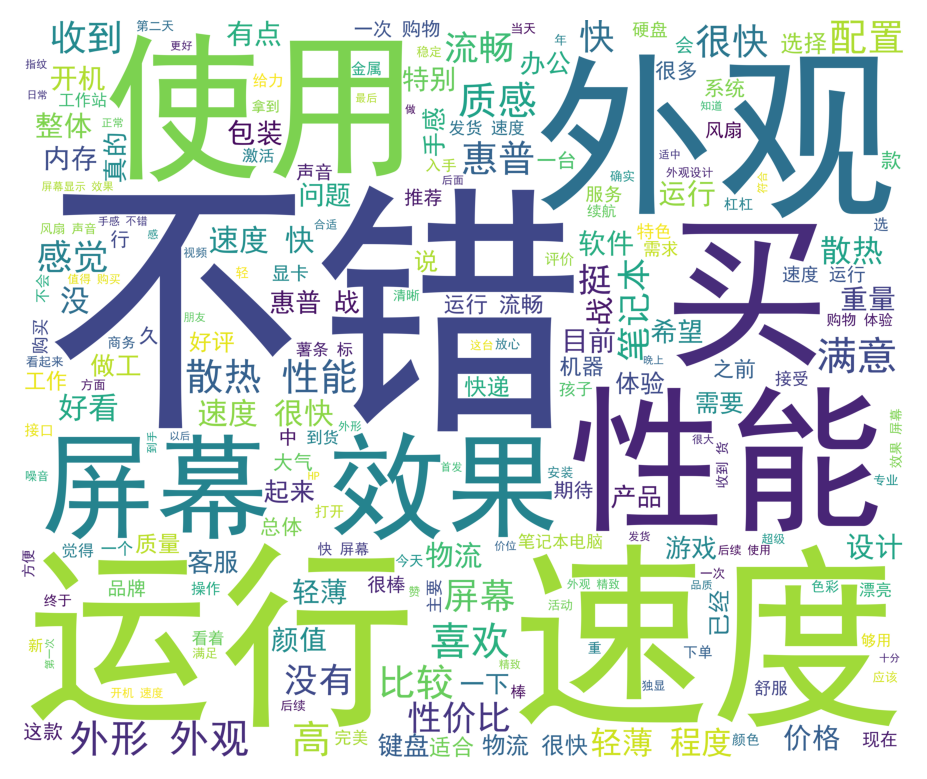

In [21]:
# 调用函数生成词云图
generate_wordcloud(comment, 'cn_stopwords.txt')

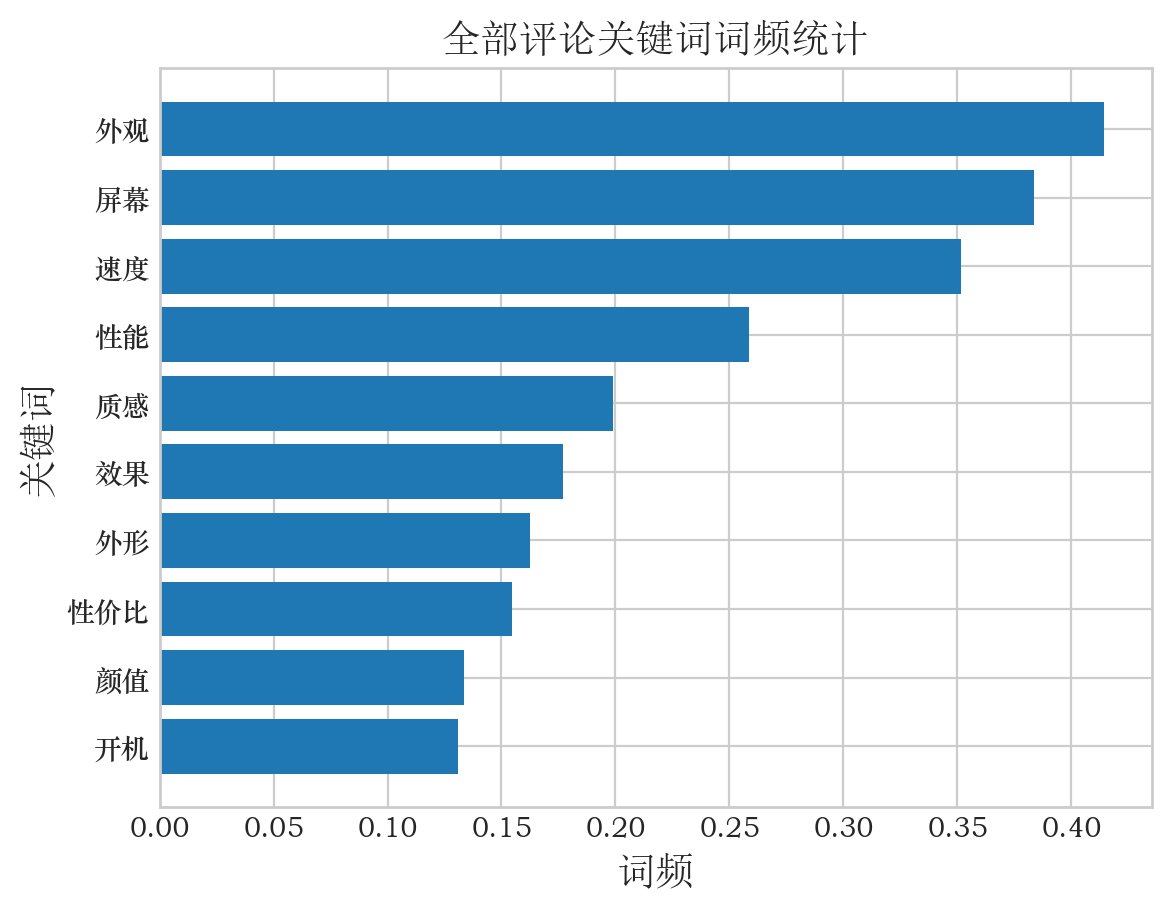

In [22]:
# 调用函数生成词频柱状图
generate_word_frequency_plot(comment, 'cn_stopwords.txt')

### 好评

In [23]:
# 数据读取及预处理
file_path = 'data/JDComment_HPzhan99_好评.csv'

# 调用函数进行评论数据预处理
data = preprocess_comment_data(file_path)

In [24]:
# 数据
# 所有评论
comment = data['content']
# 中差评
nonPos_comment = data[data['Sentiment'] != 'positive']['content']

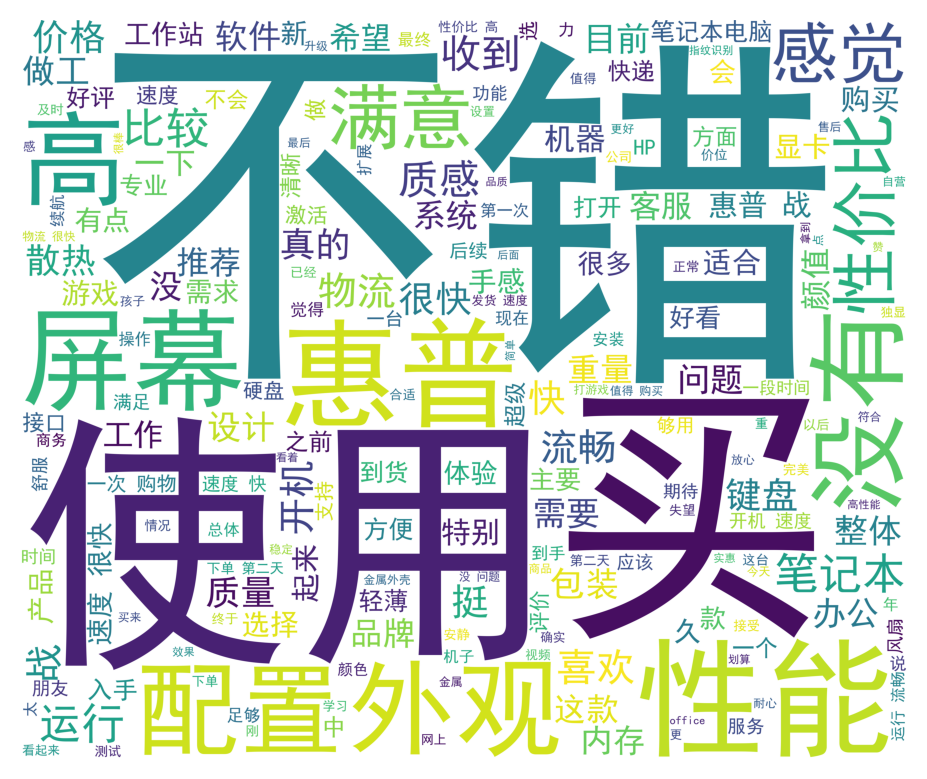

In [25]:
# 调用函数生成词云图
generate_wordcloud(comment, 'cn_stopwords.txt')

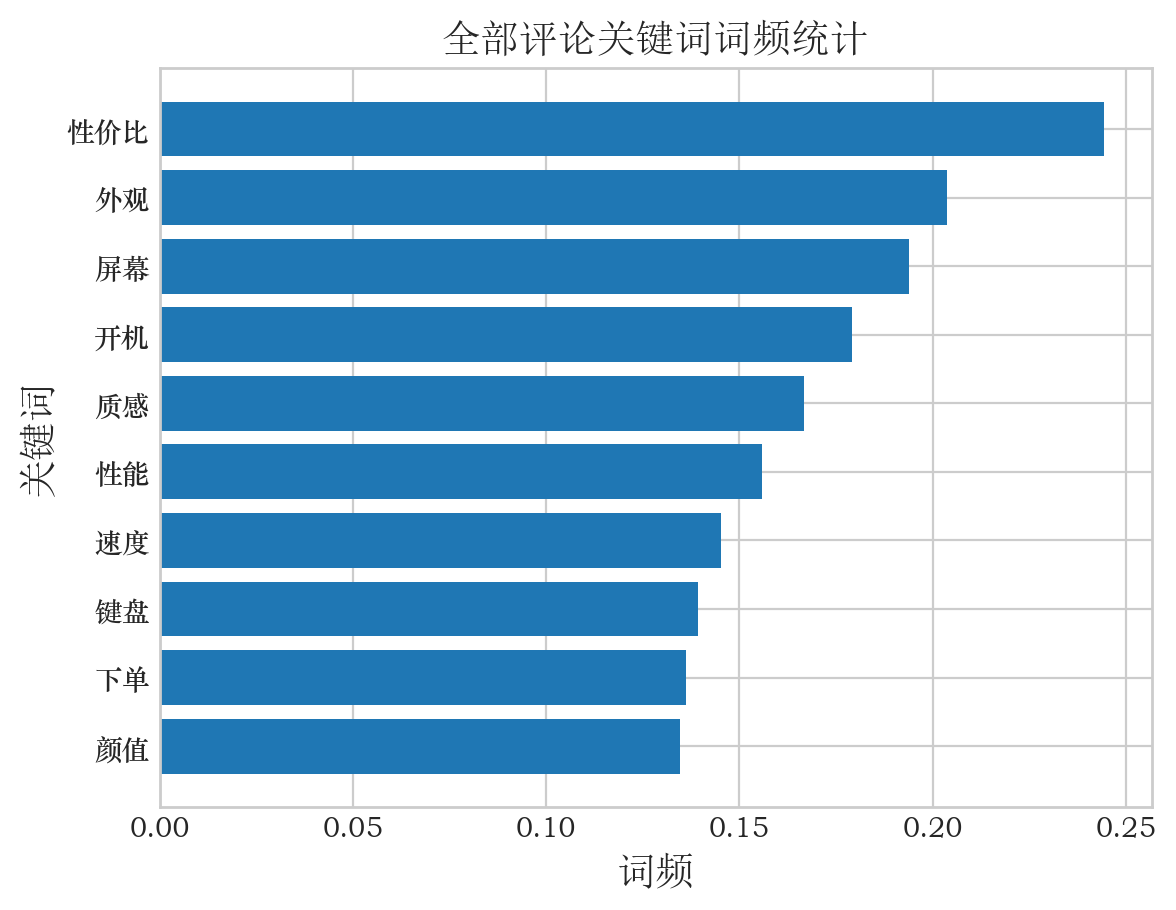

In [26]:
# 调用函数生成词频柱状图
generate_word_frequency_plot(comment, 'cn_stopwords.txt')

### 中差评

In [27]:
# 数据读取及预处理
file_path1 = 'data/JDComment_HPzhan99_中评.csv'
file_path2 = 'data/JDComment_HPzhan99_差评.csv'

# 调用函数进行评论数据预处理
data1 = preprocess_comment_data(file_path1)
data2 = preprocess_comment_data(file_path2)

data = pd.concat([data1,data2])
data.drop_duplicates()

data = data[data['content']!=""]
comment = data['content']

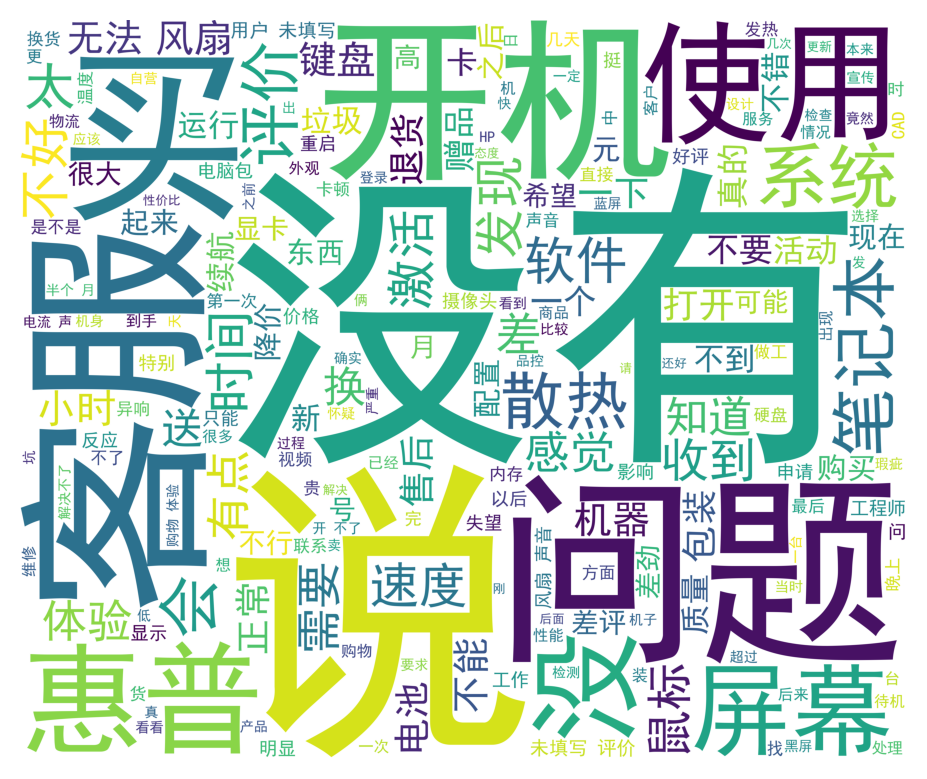

In [28]:
# 调用函数生成词云图
generate_wordcloud(comment, 'cn_stopwords.txt')

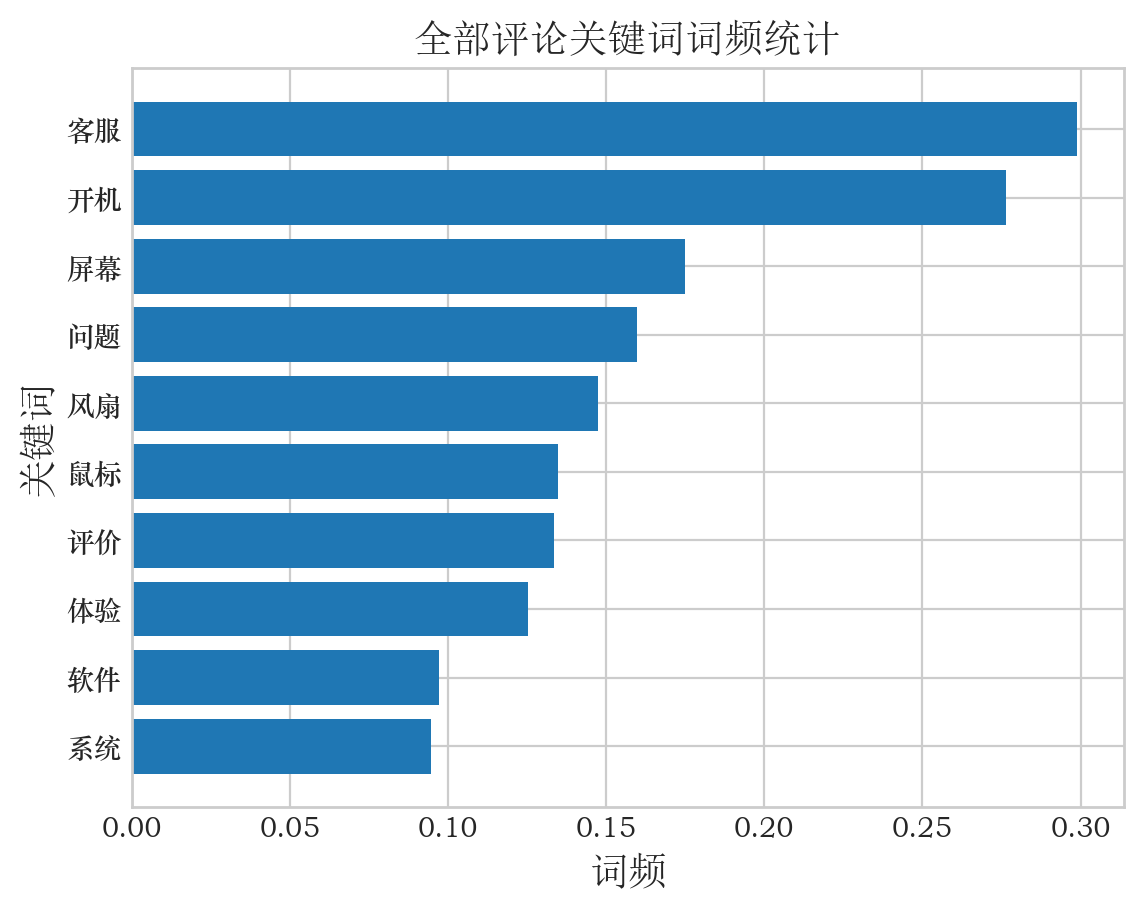

In [29]:
# 调用函数生成词频柱状图
generate_word_frequency_plot(comment, 'cn_stopwords.txt')